In [7]:
from scipy.signal import find_peaks
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import tekwfm  # assuming you have this module

In [8]:
doVerbose = False
filename_base = "PMT1_rawdata/131125_darkrate_1750_10000_1_on"
startEvent = 0
nEvents = 10000

baseline_end_frac = 0.15
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99

v_window_size = (-25e-3, 225e-3)  # allowable voltage range
tolerance = 0

volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_base + ".wfm")
samples = volts.shape
tstop = samples[0] * tscale + tstart
sampleTimes = np.array([tstart + x*tscale for x in range(samples[0])])

# Flip voltages if needed
negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)]
tempVolts = [-v for v in negVolts]

In [9]:
def calcbaseline(tempVolt, samples):
    baseline_voltages = tempVolt[0:int(baseline_end_frac*samples[0])]
    mean_b = np.mean(baseline_voltages)
    sigma_b = np.std(baseline_voltages, ddof=1)
    corrected_tempVolt = tempVolt - mean_b
    return mean_b, sigma_b, corrected_tempVolt

mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []

for i, tempVolt in enumerate(tempVolts):
    if np.any((tempVolt >= v_window_size[0] - tolerance) & (tempVolt <= v_window_size[0])):
        continue  # discard events out of window
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array)
sigma_b_array = np.array(sigma_b_array)
corrected_tempVolts = np.array(corrected_tempVolts)

In [10]:
# Parameters
min_peak_sep = int(0.05*samples[0])  # minimum separation in samples
multipliers = np.linspace(3, 23, 11)  # threshold multipliers
prominance = 0.005

In [11]:
# Storage
event_numbers_by_multiplier = []
multiple_maxima_by_multiplier = []
maxima_counts_by_multiplier = []
maxima_distribution_by_multiplier = []  # {0: x, 1: y, ...} for each multiplier


C:\Users\holly\AppData\Local\Temp\ipykernel_40780\4161235823.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(multipliers))


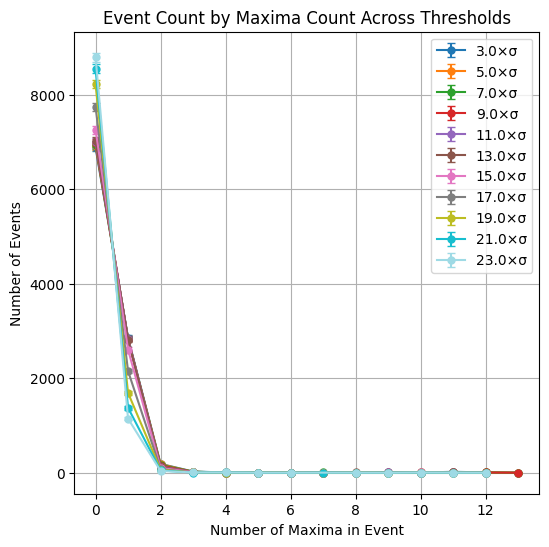

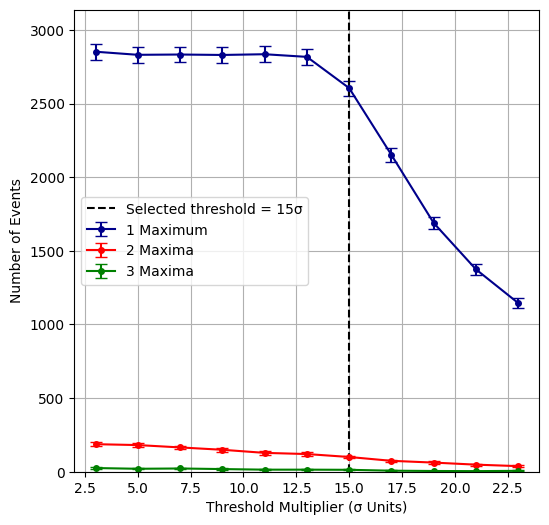

: 

In [ ]:
# Loop over threshold multipliers
for multiplier in multipliers:
    number_of_maxima_all = []
    number_of_multiple_maxima = []
    event_numbers = []

    # Loop over events
    for event_index, corrected_tempVolt in enumerate(corrected_tempVolts):
        # Threshold for this event
        maximum_threshold = multiplier * sigma_b_array[event_index]

        # Find peaks above threshold with minimum separation
        peaks, _ = find_peaks(
            corrected_tempVolt,
            height=maximum_threshold,
            distance=min_peak_sep,
            prominence=prominance  # optional: ignores tiny fluctuations
        )

        n_peaks = len(peaks)
        number_of_maxima_all.append(n_peaks)

        # Track events with multiple maxima
        if n_peaks > 1:
            event_numbers.append(event_index)
            number_of_multiple_maxima.append(n_peaks)

    # Save results for this multiplier
    maxima_counts_by_multiplier.append(np.array(number_of_maxima_all))
    event_numbers_by_multiplier.append(np.array(event_numbers))
    multiple_maxima_by_multiplier.append(np.array(number_of_multiple_maxima))

    distribution = Counter(number_of_maxima_all)
    maxima_distribution_by_multiplier.append(distribution)

# --- Histogram plot of number of maxima per event for all multipliers ---
plt.figure(figsize=(6, 6))
colors = cm.get_cmap('tab20', len(multipliers))

for i, multiplier in enumerate(multipliers):
    distribution = maxima_distribution_by_multiplier[i]
    x = sorted(distribution.keys())  # number of maxima
    y = [distribution[k] for k in x]  # number of events
    errors = np.sqrt(y)
    plt.errorbar(x, y, yerr=errors, markersize=5, fmt='o-', color=colors(i), label=f'{multiplier:.1f}×σ', capsize=3)

plt.xlabel('Number of Maxima in Event')
plt.ylabel('Number of Events')
plt.title('Event Count by Maxima Count Across Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot counts of 1, 2, 3 maxima as a function of threshold ---
def counts_for_n_maxima(n):
    counts = [dist.get(n, 0) for dist in maxima_distribution_by_multiplier]
    return np.array(counts), np.sqrt(counts)  # errors = sqrt(N)

single_maxima_counts, single_maxima_errors = counts_for_n_maxima(1)
two_maxima_counts, two_maxima_errors = counts_for_n_maxima(2)
three_maxima_counts, three_maxima_errors = counts_for_n_maxima(3)

plt.figure(figsize=(6,6))
plt.errorbar(multipliers, single_maxima_counts, yerr=single_maxima_errors, fmt='o-', markersize=4, capsize=4, color='darkblue', label='1 Maximum')
plt.errorbar(multipliers, two_maxima_counts, yerr=two_maxima_errors, fmt='o-', markersize=4, capsize=4, color='red', label='2 Maxima')
plt.errorbar(multipliers, three_maxima_counts, yerr=three_maxima_errors, fmt='o-', markersize=4, capsize=4, color='green', label='3 Maxima')
plt.axvline(15, color='black', linestyle='--', label='Selected threshold = 15σ')
plt.xlabel('Threshold Multiplier (σ Units)')
plt.ylabel('Number of Events')
plt.ylim(0, max(single_maxima_counts.max(), two_maxima_counts.max(), three_maxima_counts.max())*1.1)
plt.legend()
plt.grid(True)
plt.show()


